# refactoring for speed

In [1]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn.manifold import spectral_embedding
from sklearn import svm
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state, check_array, check_symmetric
from sklearn.utils.extmath import _deterministic_vector_sign_flip
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import kneighbors_graph

from scipy import ndimage

from scipy import stats
from scipy import sparse
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh, lobpcg
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import laplacian as csgraph_laplacian

from matplotlib import pyplot as plt
from importlib import reload

import scipy
import numpy as np

import matplotlib as mpl
import warnings
import random
import itertools
import lib
import inspect
import time

from lib import bi_cross_support
from lib import spectral_cluster_support
reload(spectral_cluster_support)
reload(bi_cross_support)


<module 'lib.bi_cross_support' from '/reg/neh/home5/sioan/Desktop/git_version_controlled/bcv_spectral_clustering/lib/bi_cross_support.py'>

In [2]:
my_matrix = np.random.rand(1000,7)
my_matrix = np.dot(my_matrix,np.random.rand(7,206))
print(my_matrix.shape)

(1000, 206)


In [3]:
rand_size = 13
n_features = 206
n_samples = 1000
my_matrix = stats.ortho_group.rvs(rand_size)
my_matrix = np.dot(my_matrix,np.random.rand(rand_size,n_features))
my_matrix = np.dot(np.random.rand(n_samples,rand_size),my_matrix)+np.random.rand(n_samples,n_features)*1e-1
print(my_matrix.shape)

(1000, 206)


In [4]:
my_prediction = bi_cross_support.predict_vs_k(my_matrix,k_list=np.arange(1,int(my_matrix.shape[1]/1)))
k,scores = np.array([i for i in my_prediction]).transpose()
k[np.argmin(scores)]

13.0

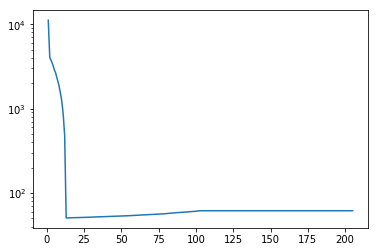

In [5]:
plt.semilogy(k,scores)

In [6]:
k,score_list = bi_cross_support.score_fast(my_matrix,n_iterations=30,k_list=np.arange(1,int(my_matrix.shape[1]/2)))

Progress: [####################] 100.0%


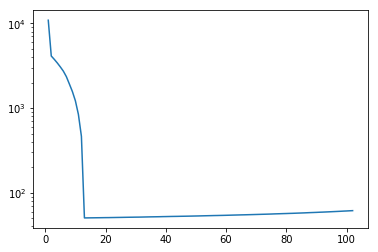

In [7]:
plt.semilogy(k,np.median(score_list,axis=0))

In [8]:
k[np.argmin(np.median(score_list,axis=0))]

13.0

# alternative to protein

In [674]:
xx,yy = np.meshgrid(np.arange(1024),np.arange(1024))

In [675]:
xx.shape

(1024, 1024)

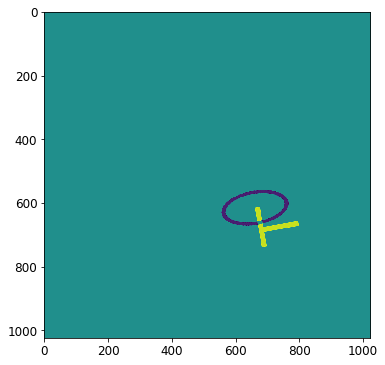

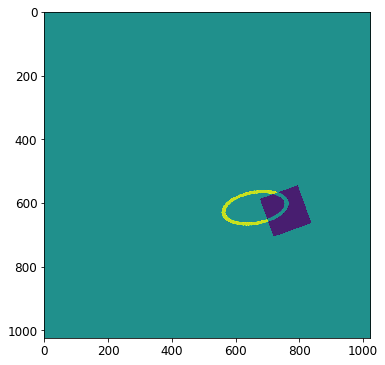

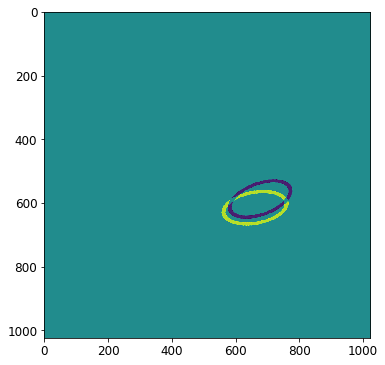

In [676]:
my_square = np.zeros([1024,1024])
my_square[512+128:512+254,512+128:512+254]=1

my_cross = np.zeros([1024,1024])
my_cross[512+128:512+254,512+128:512+144]=1
my_cross[512+128+64:512+128+80,512+128:512+254]=1

my_circle = np.around((np.exp(-(xx-512-128)**2/128**2+-(yy-512-128)**2/64**2)))
my_circle -= np.around((np.exp(-(xx-512-128)**2/112**2+-(yy-512-128)**2/52**2)))


#plt.imshow(ndimage.rotate(my_square_image,200,reshape=False))
#plt.show()
#plt.imshow(ndimage.rotate(my_cross_image,200,reshape=False))
#plt.show()

plt.imshow(ndimage.rotate(my_cross,10,reshape=False)-ndimage.rotate(my_circle,10,reshape=False))
plt.show()

plt.imshow(ndimage.rotate(my_circle,10,reshape=False)-ndimage.rotate(my_square,20,reshape=False))
plt.show()


plt.imshow(ndimage.rotate(my_circle,10,reshape=False)-ndimage.rotate(my_circle,20,reshape=False))
plt.show()


In [ ]:


theta = np.arange(1,10,1)

euclidean_dist_matrix = np.zeros([3*len(theta),3*len(theta)])

def make_euclidean_distance(image1,image2,rotation1,rotation2):
    return np.sum((ndimage.rotate(image1,rotation1,reshape=False)-ndimage.rotate(image2,rotation2,reshape=False))**2)

for i in np.arange(len(theta)):
    for j in np.arange(len(theta)):
        bi_cross_support.update_progress((i*len(theta)+j*1.0)/len(theta)**2)
        euclidean_dist_matrix[i,j] = make_euclidean_distance(my_circle,my_circle,theta[i],theta[j])
        euclidean_dist_matrix[i+len(theta),j+len(theta)] = make_euclidean_distance(my_cross,my_cross,theta[i],theta[j])
        euclidean_dist_matrix[i+2*len(theta),j+2*len(theta)] = make_euclidean_distance(my_square,my_square,theta[i],theta[j])

        euclidean_dist_matrix[i,j+len(theta)] = make_euclidean_distance(my_circle,my_cross,theta[i],theta[j])
        euclidean_dist_matrix[i+len(theta),j] = euclidean_dist_matrix[i,j+len(theta)]

        euclidean_dist_matrix[i,j+2*len(theta)] = make_euclidean_distance(my_circle,my_square,theta[i],theta[j])
        euclidean_dist_matrix[i+2*len(theta),j] = euclidean_dist_matrix[i,j+2*len(theta)]

        euclidean_dist_matrix[i+len(theta),j+2*len(theta)] = make_euclidean_distance(my_square,my_cross,theta[i],theta[j])
        euclidean_dist_matrix[i+2*len(theta),j+len(theta)] = euclidean_dist_matrix[i+len(theta),j+2*len(theta)]



In [ ]:
plt.imshow(euclidean_dist_matrix)

# protein

In [71]:
euclidean_dist_matrix = np.load("/reg/neh/home/yoon82/temp/L2_dist_2160_1D.npy")

In [72]:
#forcing first block  of matrix to have one null space
#for i in np.arange(299): euclidean_dist_matrix[i,i+1] =100
#for i in np.arange(299): euclidean_dist_matrix[i+1,i] =100

#  BCV analysis

## calculating laplacian

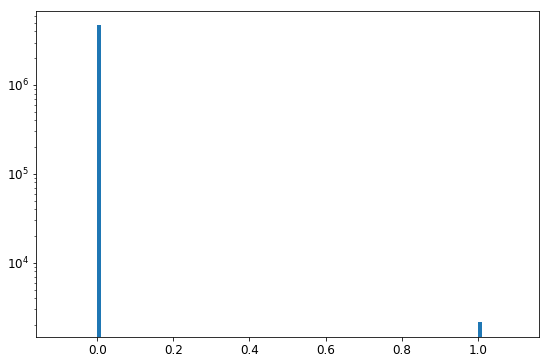

In [124]:
gamma = 5.0e-4
my_affinity_matrix = np.exp((-(euclidean_dist_matrix**2))*gamma)
#degree_matrix      = np.diag((my_affinity_matrix - np.diag(np.diag(my_affinity_matrix))).sum(axis=0))
#laplcian = my_affinity_matrix - degree_matrix
my_hist = plt.hist(my_affinity_matrix.flatten(),bins=np.arange(-0.1,1.1,0.01),log=True)

In [125]:
spectral = cluster.SpectralClustering(n_clusters=2,                     #intentionally incorrect clusters
                                      assign_labels="discretize",
                                      random_state=10,
                                      gamma=gamma,                        #this hyper parameter can estimated using BCV-Loss
                                      affinity = 'rbf')
spectral.fit(np.random.rand(100,3))

SpectralClustering(affinity='rbf', assign_labels='discretize', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=0.0005,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=10)

In [126]:
#using the modified sci-kit learn package to convert the affinity matrix
laplacian,my_embedding = lib.spectral_cluster_support.get_laplacian(my_affinity_matrix,
                                n_components = int(my_affinity_matrix.shape[0]/2),
                                eigen_solver = spectral.eigen_solver,
                                random_state = spectral.random_state)

In [127]:
#regularization_parameter = 1e-14
#y_stack = np.linalg.inv(spectral_cluster_support.condition_matrix(laplacian,regularization_parameter))
y_stack = np.linalg.inv(laplacian+1e-26*np.random.rand(laplacian.shape[0],laplacian.shape[0]))+0*1e4*np.random.rand(laplacian.shape[0],laplacian.shape[0])

In [128]:
k,score_list = bi_cross_support.score_fast(y_stack,n_iterations=10,k_list=np.arange(1,12))

Progress: [####################] 100.0%


In [129]:
k[np.argmin(np.median(score_list,axis=0))]

3.0

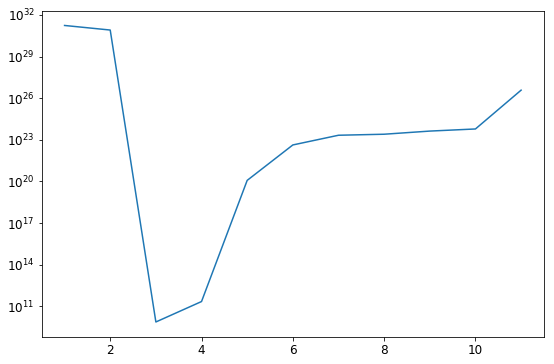

In [130]:
plt.semilogy(k,np.median(score_list,axis=0))

In [80]:
# iterating over many gamma's

In [114]:
score_map = []
gamma_list = np.arange(1e-5,6e-4,1e-5)


spectral = cluster.SpectralClustering(n_clusters=2,                     #intentionally incorrect clusters
                                      assign_labels="discretize",
                                      #random_state=10,
                                      gamma=gamma,                        #this hyper parameter can estimated using BCV-Loss
                                      affinity = 'rbf')

for gamma in gamma_list:
    my_affinity_matrix = np.exp((-(euclidean_dist_matrix**2))*gamma)
    
    
    laplacian,my_embedding = lib.spectral_cluster_support.get_laplacian(my_affinity_matrix,
                                n_components = int(my_affinity_matrix.shape[0]/2),
                                eigen_solver = spectral.eigen_solver,
                                random_state = spectral.random_state)
    
    #y_stack = np.linalg.inv(spectral_cluster_support.condition_matrix(laplacian,1e-26))
    #y_stack +=1e4*np.random.rand(laplacian.shape[0],laplacian.shape[0])
    y_stack = np.linalg.inv(laplacian+1e-26*np.random.rand(laplacian.shape[0],laplacian.shape[0]))+0*1e4*np.random.rand(laplacian.shape[0],laplacian.shape[0])
    
    k,score_list = bi_cross_support.score_fast(y_stack,n_iterations=10,k_list=np.arange(1,15))
    score_map.append(np.median(score_list,axis=0))

Progress: [####################] 100.0%


In [115]:
full_map = np.array(score_map)
k_range = k

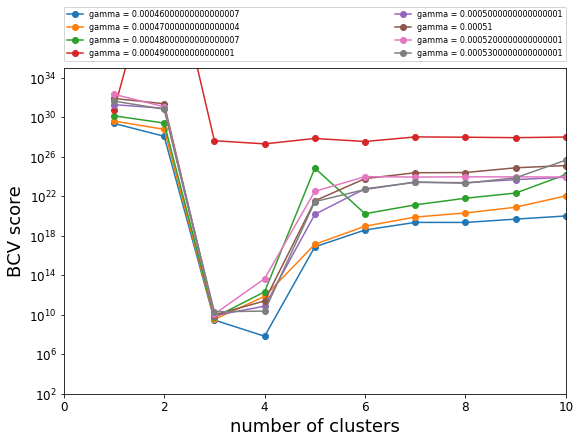

In [150]:
fig = plt.figure()
ax  = fig.add_subplot(111)



for i in np.arange(len(full_map))[-14:-6]:

    mpl.rcParams['figure.figsize']  = (9,6)
    mpl.rcParams['font.size']       = 12
    mpl.rcParams['legend.fontsize'] = 8
    mpl.rcParams['axes.labelsize']  = 18

  
    ax.semilogy(k_range,full_map[i],label="gamma = "+str(gamma_list[i]),marker='o')

ax.set_xlabel("number of clusters")
ax.set_ylim(1e2,1e35)
ax.set_xlim(0,10)
ax.set_ylabel("BCV score")
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.0)
plt.show() 